In [112]:
import os
import re
from typing import Optional, List

import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness
from timm import create_model
from einops import rearrange, reduce

In [2]:
from deep_spatial_genomics.models.x_unet import XUnet

#### train/val data

In [5]:
train_adata = sc.read_h5ad('/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/st_tme_tool_development/brca/HT397B1-S1H2A4/adata.h5ad')
train_adata.X = train_adata.layers['counts'] # using raw counts
train_adata

AnnData object with n_obs × n_vars = 3561 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'alla_label', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'alla_label_colors', 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
val_adata = sc.read_h5ad('/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/st_tme_tool_development/brca/HT397B1-S1H3A1/adata.h5ad')
val_adata.X = val_adata.layers['counts'] # using raw counts
val_adata

AnnData object with n_obs × n_vars = 3494 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

#### preprocessing

Instead of tiling the data and training on non-overlapping patches, we sample patch coordinates uniformly random from the section surfaces and extract patches directly from the dataset during learning. Patches are distorted with uniformly sampled rotations from (0∘, 360∘), scaling from (0.95, 1.05) and shearing from (0∘, 10∘). The image data are further distorted with random brightness, contrast, saturation and hue jitter independently sampled from (−5%, 5%).

In [73]:
t = ColorJitter(brightness=.1, contrast=.1, saturation=.1, hue=.1)
# t = RandomAdjustSharpness(.5, p=1)

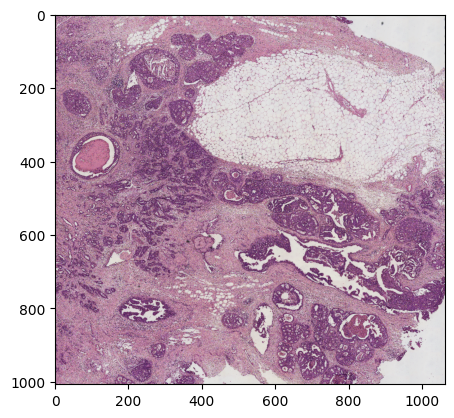

In [75]:
img = rearrange(torch.tensor(train_adata.uns['rescaled_he']['16X_trimmed']), 'h w c -> c h w')
transfomed = rearrange(t(img), 'c h w -> h w c')
plt.imshow(transfomed)

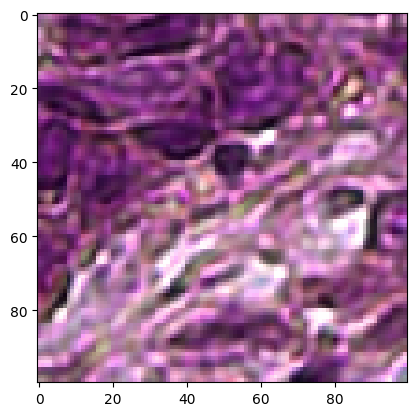

In [77]:
img = rearrange(torch.tensor(train_adata.uns['rescaled_he']['1X_trimmed'])[5000:5100, 5000:5100], 'h w c -> c h w')
transfomed = rearrange(t(img), 'c h w -> h w c')
plt.imshow(transfomed)

In [106]:
class HETransform(object):
    def __init__(self, p=.8, brightness=.1, contrast=.1, saturation=.1, hue=.1, sharpness=.3):
        self.color_transforms = torch.nn.Sequential(
            ColorJitter(brightness=.1, contrast=.1, saturation=.1, hue=.1),
            RandomAdjustSharpness(.3)
        )
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.sharpness = sharpness
        
        self.normalize = Normalize((0.771, 0.651, 0.752), (0.229, 0.288, 0.224)), # from HT397B1-H2 ffpe H&E image
 
        self.p = .8
    
    def apply_color_transforms(self, x, brightness, contrast, saturation, hue, sharpness):
        x = TF.adjust_brightness(x, brightness)
        x = TF.adjust_contrast(x, contrast)
        x = TF.adjust_saturation(x, saturation)
        x = TF.adjust_hue(x, hue)
        x = TF.adjust_sharpness(x, sharpness)
        return x
        
    def __call__(self, he, mask):
        """
        """
        if isinstance(he, torch.Tensor):
            hes = [he]
            masks = [mask]
            return_type = 'image'
        elif isinstance(he, dict):
            hes = he.values()
            masks = mask.values()
            return_type = 'dict'
        else:
            return_type = 'list'
        
        # we apply transforms with probability p
        if torch.rand(size=(1,)) < self.p:
            brightness, contrast, saturation, hue, sharpness = (
                np.random.uniform(max(0, 1 - self.brightness), 1 + self.brightness, size=1)[0],
                np.random.uniform(max(0, 1 - self.contrast), 1 + self.contrast, size=1)[0],
                np.random.uniform(max(0, 1 - self.saturation), 1 + self.saturation, size=1)[0],
                np.random.uniform(max(0, 1 - self.hue), 1 + self.hue, size=1)[0],
                np.random.uniform(max(0, 1 - self.sharpness), 1 + self.sharpness, size=1)[0],
            )
            # apply color jitter and sharpness
            hes = [self.apply_color_transforms(x, brightness, contrast, saturation, hue, sharpness)
                   for x in hes]
            
            # vertical and horizontal flips happen with p=.5
            do_hflip, do_vflip = torch.rand(size=(2,)) < .5 
            if do_hflip:
                hes = [TF.hflip(x) for x in hes]
                masks = [TF.hflip(x) for x in masks]
            if do_vflip:
                hes = [TF.vflip(x) for x in hes]
                masks = [TF.vflip(x) for x in masks]
                
        hes = [self.normalize(x) for x in hes]
            
        if return_type == 'image':
            return hes[0], masks[0]
        elif return_type == 'dict':
            return {k:v for k, v in zip(he.keys(), hes)}, {k:v for k, v in zip(mask.keys(), hes)}
        return hes, masks

In [145]:
def convert_rgb(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
        
    if not isinstance(img, torch.Tensor):
        img = torch.Tensor(img)
        
    if not img.dtype == torch.float32:
        img = TF.convert_image_dtype(img, dtype=torch.float32)
    
    return img


def reflection_pad(img, r1, r2, c1, c2):
    tile = img[max(r1, 0):r2, max(c1, 0):c2]
    
    top_pad = -min(0, r1)
    bottom_pad = -min(0, img.shape[0] - r2)
    left_pad = -min(0, c1)
    right_pad = -min(0, img.shape[1] - c2)
    
    return TF.pad(tile, padding=[left_pad, top_pad, right_pad, bottom_pad], padding_mode='reflect')


class STDataset(Dataset):
    """ST Dataset"""
    def __init__(self, adata, he_dict, mask_dict,
                 tile_sizes=512, use_raw=False, he_transform=None):
        """
        adata: AnnData object
            - .X must be unnormalized counts
            - must have column in .obs['spot_index'] that specified the spot index in the scaled mask dict
        scaled_he_dict: dict
            - values are rgb H&E images, keys are '[0-9]+X', where the integer in front of X is the scale factor of the H&E image.
        scaled_mask_dict: dict
            - values are labeled images where 0 is background and all other pixels coorespond to index stored in .obs['spot_index'].
        """
        super().__init__()
        # make sure we are ordered by spot index
        self.spot_ids, _ = zip(*sorted([(sid, sidx) for sid, sidx in zip(adata.obs.index, adata.obs['spot_index'])],
                                    key=lambda x: x[1]))
        self.spot_ids = np.asarray(self.spot_ids)
        self.adata = adata[self.spot_ids]
        self.he_dict = {k:convert_rgb(v) for k, v in he_dict.items()}
        self.mask_dict = {k:torch.Tensor(v).to(torch.int32) if not isinstance(v, torch.Tensor) else v
                                 for k, v in mask_dict.items()}
        self.scales = sorted([int(re.sub(r'^([0-9]+)X$', r'\1', k)) for k in self.he_dict.keys()])
        
        self.idx_to_pixel = {}
        _, n_row, n_col = self.he_dict[str(self.scales[0]) + 'X'].shape
        idx = 0
        for r in np.arange(n_row):
            for c in np.arange(n_col):
                self.idx_to_pixel = [
                    {f'{s}X': (int(r / s), int(c / s)) for s in self.scales}
                ]
                idx += 1
        
        if isinstance(tile_sizes, int):
            self.tile_sizes = [tile_sizes] * len(he_dict)
        self.tile_sizes = tile_sizes # defines the size of crops to be taken from each h&e resolution
        self.he_transform = he_transform

    def __len__(self):
        return len(self.idx_to_pixel)

    def __getitem__(self, idx):
        d = self.idx_to_pixel[idx]
        
        he_dict, mask_dict = {}, {}
        for scale, he, mask, tile_size in zip(self.scales, self.he_dict,
                                              self.mask_dict, self.tile_sizes):
            key = f'{scale}X'
            r, c = d[key]
            r, c = int(r - (tile_size / 2)), int(c - (tile_size / 2))
            he_dict[key] = reflection_pad(he, r, r + tile_size, c, c + tile_size)
            mask_dict[key] = reflection_pad(mask, r, r + tile_size, c, c + tile_size)
            
        if self.he_transform is not None:
            he_dict, mask_dict = he_transform(he_dict, mask_dict)
        
        spot_idxs = torch.unique(mask_dict[str(self.scales[-1]) + 'X']).numpy() - 1
        
        if use_raw:
            x = self.adata.raw.X[spot_idxs]
        else:
            x = self.adata.X[spot_idxs]
        
        if 'sparse' in str(type(x)).lower():
            x = x.toarray()

        return {
            'X': x,
            'he_tiles': he_dict,
            'mask_tiles': mask_dict,
            'spot_idxs': spot_idxs
        }

In [110]:
train_adata

AnnData object with n_obs × n_vars = 3561 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'alla_label', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'alla_label_colors', 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [138]:
he_dict = {re.sub(r'^([0-9]+X).*$', r'\1', k):v for k, v in train_adata.uns['rescaled_he'].items()
           if re.findall(r'^[0-9]+X.*$', k) and 'trimmed' in k}
mask_dict = {re.sub(r'^([0-9]+X).*$', r'\1', k):v for k, v in train_adata.uns['rescaled_spot_masks'].items()
             if re.findall(r'^[0-9]+X$', k) and 'trimmed' in k}

In [139]:
he_dict.keys()

dict_keys(['16X', '1X', '2X', '4X', '8X'])

In [146]:
he_transform = HETransform()
ds = STDataset(train_adata, he_dict, mask_dict, tile_sizes=512, he_transform=he_transform)

KeyboardInterrupt: 

In [131]:
torch.float32==torch.float16

False

In [13]:
def get_train_dataloaders(train, val, spot_to_full_res, batch_size=64):
    """
    Get train and validation dataloaders.
    Arguments
    ---------
    train: str or AnnData
        - AnnData object or filepath of saved AnnData with .h5ad ext to be used for training
    val: str or AnnData
        - AnnData object or filepath of saved AnnData with .h5ad ext to be used for validation
    spot_to_full_res: dict
        - maps spot ID to full res H&E tile
    batch_size: int
        - batch size for dataloaders
    """
    train_adata = sc.read_h5ad(train) if isinstance(train, str) else train
    val_adata = sc.read_h5ad(val) if isinstance(val, str) else val

    train_ds = PollockDataset(train_adata, spot_to_full_res)
    val_ds = PollockDataset(val_adata, spot_to_full_res)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, )
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_dl, val_dl

In [ ]:
torch.utils.data.TensorDataset()

#### model

In [7]:
"""
modified from https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31
"""
class Unet(nn.Module):
    """Unet is a fully convolution neural network for image semantic segmentation
    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        center: if ``True`` add ``Conv2dReLU`` block on encoder head
    NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
    """

    def __init__(
            self,
            backbone='resnet50',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=1,
            num_classes=5,
            center=False,
            norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=True, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x


class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UnetDecoder(nn.Module):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

In [10]:
class xFuse(nn.Module):
    def __init__(self, n_genes, voxel_size, n_covariates,
                 n_metagenes=20, latent_dim=64, in_channels=3, decoder_channels=(64, 32, 16),
                 kl_scaler = .001, latent_scaler=1., L_scaler=1., E_scaler=1., F_scaler=1.):
        super().__init__()
        
        self.unet = Unet(backbone='resnet50',
                        decoder_channels=(64, 32, 16),
                        in_chans=in_channels,
                        num_classes=latent_dim)
        
        self.n_genes = n_genes
        self.voxel_size = voxel_size
        self.n_metagenes = n_metagenes
        self.latent_dim = latent_dim
        
        # scalers for KL loss on q for latent, L, E, and F
        self.latent_scaler = latent_scaler
        self.L_scaler = L_scaler
        self.E_scaler = E_scaler
        self.F_scaler = F_scaler
        self.kl_scaler = kl_scaler
        
        # gene-wise baselines for r and p
        self.t = nn.Parameter(torch.randn(self.n_genes))
        self.u = nn.Parameter(torch.randn(self.n_genes))
        
        # latent mu and var
        self.latent_mu = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)
        self.latent_var = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)
        
        # creates initial metagene matrix - (b, H, W, m)
        self.h = nn.Sequential(
            nn.Conv2d(in_channels=latent_dim, out_channels=self.n_metagenes, kernel_size=1),
            nn.Softmax(dim=-1)
        )
        
        # creates scale factor for each pixel - (1, H, W)
        self.s = nn.Sequential(
            nn.Conv2d(in_channels=latent_dim, out_channels=1, kernel_size=1),
            nn.Softplus()
        )
        
        # gene activity matrix - (m, g)
        self.L = nn.Parameter(torch.randn(self.n_metagenes, self.n_genes))
        self.L_mu = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)
        self.L_var = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)
        
        # E - (D, g) - covariate matrix for r
        self.E = nn.Parameter(torch.randn(self.n_covariates, self.n_genes))
        self.E_mu = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)
        self.E_var = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)
        
        # F - (D, g) - covariate matrix for p
        self.F = nn.Parameter(torch.randn(self.n_covariates, self.n_genes))
        self.F_mu = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)
        self.F_var = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)
        
        self.reconstruction_loss = nn.MSELoss()
        
    def _sample_q(self, mu, log_var, use_means=False):
        # sample z from parameterized distributions
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        # get our latent
        if use_means:
            z = mu
        else:
            z = q.rsample()

        return z, mu, std
    
    def _kl_divergence(self, z, mu, std):
        # lightning imp.
        # Monte carlo KL divergence
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)

        return kl
    
    def calculate_loss(self, x_raw, result):
        nb = torch.distributions.NegativeBinomial(result['r'], result['p'])
        reconstruction_loss = torch.mean(-nb.log_prob(x_raw))
        
        latent_loss = torch.mean(self.kl_divergence(result['z'], result['z_mu'], result['z_std']))
        L_loss = torch.mean(self.kl_divergence(result['L'], result['L_mu'], result['L_std']))
        E_loss = torch.mean(self.kl_divergence(result['E'], result['E_mu'], result['E_std']))
        F_loss = torch.mean(self.kl_divergence(result['F'], result['F_mu'], result['F_std']))

        kl_loss = (
            latent_loss * self.latent_scaler,
            L_loss * self.L_scaler,
            E_loss * self.E_scaler,
            F_loss * self.F_scaler
        )

        return {
            'overall_loss': reconstruction_loss + self.kl_scaler * kl_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss,
            'latent_loss': latent_loss,
            'L_loss': L_loss,
            'E_loss': E_loss,
            'F_loss': F_loss,
        }
        
    def encode(self, x, use_means=False):
        x_encoded = self.unet(x)
        
        mu, log_var = self.latent_mu(x_encoded), self.latent_var(x_encoded)

        return self._sample_q(mu, log_var, use_means=use_means), mu, log_var
        
    def sample_L(self, use_means=False):
        mu, log_var = self.L_mu(self.L), self.L_var(self.L)

        return self._sample_q(mu, log_var, use_means=use_means), mu, log_var
    
    def sample_E(self, use_means=False):
        mu, log_var = self.E_mu(self.E), self.E_var(self.E)

        return self._sample_q(mu, log_var, use_means=use_means), mu, log_var
    
    def sample_F(self, use_means=False):
        mu, log_var = self.F_mu(self.F), self.F_var(self.F)

        return self._sample_q(mu, log_var, use_means=use_means), mu, log_var
        
    def metagenes_from_latent(self, z):
        h = self.h(z) # (b, m, H, W)
        s = self.s(z) # (1, H, W, 1)
        return rearrange(h * s, 'b c h w -> b h w c')
    
    def parameterize_nb(self, z, b, voxel_level=True, use_means=False, return_intermediates=False):
        """
        reconstruct expression from latent z and covariate vector b
        
        z - (b, H, W, latent_dim)
        b - (b, D)
        """
        h = self.metagenes_from_latent(z) # (b, H, W, m)
        
        if voxel_level:
            # aggregate and sum pixels to the voxel level where Hv and Wv are height and width in terms of voxels
            h = reduce(h, 'b (h h2) (w w2) c -> b h w c', 'sum',
                       h2=voxel_size, w2=voxel_size) # (b, Hv, Wv, m)
        
        # calculate r for each gene
        L, L_mu, L_std = self.sample_L(use_means=use_means) # (m, g)
        r = h@L # (b, Hv, Wv, g)
        
        # adjust for covariates
        E, E_mu, E_std = self.sample_E(use_means=use_means) # (D, g)
        adj = torch.exp(b@E + self.t) # (1, g)
        r *= adj # (b, Hv, Wv, g)
        
        # calculate p
        F, F_mu, F_std = self.sample_F(use_means=use_means)
        p = torch.sigmoid(b@F + self.u) # (b, g)
        
        if return_intermediates:
            return {
                'L': L,
                'L_mu': L_mu,
                'L_std': L_std,
                'E': E,
                'E_mu': E_mu,
                'E_std': E_std,
                'F': F,
                'F_mu': F_mu,
                'F_std': F_std,
                'metagene_matrix': h,
                'r': r,
                'p': p
            }
        
        return r, p
    
    def forward_with_expression(self, x, b, use_means=False, voxel_level=True):
        result = self.forward(x, b, voxel_level=voxel_level,
                              use_means=use_means, return_intermediates=True)
        r, p = result['r'], result['p']
        
        # get expression from negative binomial
        nb = torch.distributions.NegativeBinomial(r, p)
        result['expression'] = nb.mean()
                
        return result
    
    def forward(self, x, b, voxel_level=True, use_means=False, return_intermediates=True):
        z, z_mu, z_std = self.encode(x, use_means=use_means)
        result = self.parameterize_nb(z, b, voxel_level=voxel_level,
                                      use_means=use_means, return_intermediates=return_intermediates)
        result.update({
            'z': z,
            'z_mu': z_mu,
            'z_std': z_std
        })
        
        return result
        
    
    

In [ ]:
model = xFuse(
    n_genes, voxel_size, n_covariates,
    n_metagenes=20, latent_dim=64, in_channels=3, decoder_channels=(64, 32, 16),
    kl_scaler = .001, latent_scaler=1., L_scaler=1., E_scaler=1., F_scaler=1.)

In [60]:
r = F.softplus(torch.randn(1, 5, 5, 100))
p = torch.sigmoid(torch.randn(1, 100))

nb = torch.distributions.NegativeBinomial(r, p)
s = nb.sample()
log_prob = -nb.log_prob(s)
log_prob.shape



torch.Size([1, 5, 5, 100])

In [56]:
nb.mean

tensor([ 10.0000, 180.0000,   1.0000])

In [58]:
r = torch.Tensor([10., 20., 1.])
p = torch.Tensor([.5, .9, .5])

nb = torch.distributions.NegativeBinomial(r, p)
s = nb.sample()
log_prob = -nb.log_prob(s)
s, log_prob



(tensor([ 15., 208.,   2.]), tensor([3.2450, 5.0071, 2.0794]))

In [50]:
a = torch.randn(1, 50, 50, 20)
reduce(a, 'b (h h2) (w w2) c -> b h w c', 'sum', h2=10, w2=10).shape

torch.Size([1, 5, 5, 20])

In [22]:
a = torch.randn(1, 5, 5, 20)
b = torch.randn(20, 100)
(a@b).shape

torch.Size([1, 5, 5, 100])

In [23]:
a = torch.randn(1, 50, 50, 20)
b = torch.randn(1, 20)
(a * b).shape

torch.Size([1, 50, 50, 20])

In [ ]:
class PollockModel(torch.nn.Module):
    def __init__(self, genes, classes,
                 latent_dim=64, enc_out_dim=128, middle_dim=512,
                 zinb_scaler=1., kl_scaler=1e-5, clf_scaler=1.):
        """
        Pollock VAE + classifier
        """
        super(PollockModel, self).__init__()
        self.latent_dim = latent_dim
        self.genes = genes
        self.n_genes = len(genes)
        self.classes = classes
        self.n_classes = len(classes)

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.n_genes, middle_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(middle_dim, enc_out_dim),
            torch.nn.ReLU(),
        )

        self.mu = torch.nn.Linear(enc_out_dim, latent_dim)
        self.var = torch.nn.Linear(enc_out_dim, latent_dim)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, enc_out_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_out_dim, middle_dim),
            torch.nn.ReLU(),
        )
        self.disp_decoder = torch.nn.Sequential(
            torch.nn.Linear(middle_dim, self.n_genes),
            DispAct()
        )
        self.mean_decoder = torch.nn.Sequential(
            torch.nn.Linear(middle_dim, self.n_genes),
            MeanAct()
        )
        self.drop_decoder = torch.nn.Sequential(
            torch.nn.Linear(middle_dim, self.n_genes),
            torch.nn.Sigmoid()
        )

        self.prediction_head = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, self.n_classes),
            torch.nn.Softmax(dim=1),
        )

        self.zinb_loss = ZINBLoss()
        self.ce_loss = torch.nn.CrossEntropyLoss()
        self.zinb_scaler = zinb_scaler
        self.kl_scaler = kl_scaler
        self.clf_scaler = clf_scaler

    def kl_divergence(self, z, mu, std):
        # lightning imp.
        # Monte carlo KL divergence
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)

        return kl

    def encode(self, x, use_means=False):
        x_encoded = self.encoder(x)
        mu, log_var = self.mu(x_encoded), self.var(x_encoded)

        # sample z from parameterized distributions
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        # get our latent
        if use_means:
            z = mu
        else:
            z = q.rsample()

        return z, mu, std

    def decode(self, x):
        h = self.decoder(x)
        x_disp = self.disp_decoder(h)
        x_mean = self.mean_decoder(h)
        x_drop = self.drop_decoder(h)

        return x_disp, x_mean, x_drop

    def calculate_loss(self, r, x_raw, scale_factor, y_true):
        reconstruction_loss = self.zinb_loss(
            x_raw, r['x_mean'], r['x_disp'], r['x_drop'], scale_factor=scale_factor)

        kl_loss = torch.mean(self.kl_divergence(r['z'], r['mu'], r['std']))

        clf_loss = torch.mean(self.ce_loss(r['y'], y_true))

        return ((reconstruction_loss * self.zinb_scaler) + (kl_loss * self.kl_scaler) + (clf_loss * self.clf_scaler),
                reconstruction_loss,
                kl_loss,
                clf_loss)

    def forward(self, x, use_means=False):
        z, mu, std = self.encode(x, use_means=use_means)
        x_disp, x_mean, x_drop = self.decode(z)
        y = self.prediction_head(z)

        return {
            'z': z,
            'mu': mu,
            'std': std,
            'x_disp': x_disp,
            'x_mean': x_mean,
            'x_drop': x_drop,
            'y': y
        }